In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_science_hack_functions import *
from tabulate import tabulate

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.pipeline import Pipeline, make_pipeline
import optuna

In [3]:
df = pd.read_excel(r"C:\Users\harsh\OneDrive\Desktop\MSBA\Spring 2024\Predictive Analytics\Homework\homework3\HW3.xlsx")
df.head()

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,127.87
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0.00
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127.48
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0.00
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0.00


In [3]:
summary_dataframe(df)


Summary Statistics:
╒══════════════════════╤═════════════╤════════════════╤══════════════════╤═════════════╤═════════════════╤════════════╤═══════════════════╤════════════════════════╕
│ Column Name          │ Data Type   │   Total Values │   Missing Values │   Missing % │   Unique Values │   Unique % │ Constant Column   │ Cardinality Category   │
╞══════════════════════╪═════════════╪════════════════╪══════════════════╪═════════════╪═════════════════╪════════════╪═══════════════════╪════════════════════════╡
│ sequence_number      │ int64       │           2000 │                0 │           0 │            2000 │     100    │ False             │ High                   │
├──────────────────────┼─────────────┼────────────────┼──────────────────┼─────────────┼─────────────────┼────────────┼───────────────────┼────────────────────────┤
│ US                   │ int64       │           2000 │                0 │           0 │               2 │       0.1  │ False             │ Low           

### FEATURE ENGINEERING

In [4]:
X = df.drop(columns=['Spending','sequence_number', 'Purchase'])
y = df['Spending']

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 22), (400, 22), (1600,), (400,))

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### MODEL SELECTION USING NESTED CV

In [37]:
param_grids = {
    "Linear Regression": {},  # No hyperparameters to tune
    
    "k-NN Regressor": {
        'n_neighbors': [3, 5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    
    "Decision Tree": {
        'max_depth': [3, 5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    "SVR": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    },
    
    "Neural Network": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }
}


In [38]:
models = {
    "Linear Regression": LinearRegression(),
    "k-NN Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "SVR": SVR(),
    "Neural Network": MLPRegressor(max_iter=1000),
    "Random Forest": RandomForestRegressor()
}

In [34]:
def run_nested_regression_cv(X, y, model_dict, param_grids, scoring_list=['r2'], outer_splits=5, inner_splits=3):
    """
    Performs nested CV on multiple regression models with multiple scoring metrics.
    Supports derived metrics like RMSE, MAPE, Adjusted R², RMSLE.
    Displays per-model metric scores and comparison plots (one per metric).
    """
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=42)

    y = np.ravel(y)
    results = {}
    summary_rows = []

    for model_name, model in model_dict.items():
        print(f"\n{'='*60}")
        print(f" Running Nested CV for: {model_name}")
        print(f"{'='*60}")

        needs_scaling = model_name not in ['random_forest', 'gboost']
        steps = [('scaler', StandardScaler())] if needs_scaling else []
        steps.append(('regressor', model))
        pipe = Pipeline(steps)

        param_grid = {f'regressor__{k}': v for k, v in param_grids[model_name].items()}
        results[model_name] = {}

        for scoring in scoring_list:
            print(f"\n→ Scoring Metric: {scoring.upper()}")

            actual_scoring = scoring
            postprocess = None

            # Handle custom metrics
            if scoring == 'rmse':
                actual_scoring = 'neg_mean_squared_error'
                postprocess = lambda s: np.sqrt(-s)
            elif scoring == 'rmsle':
                actual_scoring = 'neg_mean_squared_log_error'
                postprocess = lambda s: np.sqrt(-s)
            elif scoring == 'mape':
                def safe_mape_scorer(estimator, X_val, y_val):
                    y_pred = estimator.predict(X_val)
                    y_val = np.where(np.abs(y_val) < 1e-8, 1e-8, y_val)
                    return -mean_absolute_percentage_error(y_val, y_pred)
                actual_scoring = safe_mape_scorer
                postprocess = lambda s: -s
            elif scoring == 'mae':
                actual_scoring = 'neg_mean_absolute_error'
                postprocess = lambda s: -s
            elif scoring == 'adjusted_r2':
                def adjusted_r2_scorer(estimator, X_val, y_val):
                    y_pred = estimator.predict(X_val)
                    r2 = r2_score(y_val, y_pred)
                    n, p = len(y_val), X_val.shape[1]
                    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
                actual_scoring = adjusted_r2_scorer

            # Inner CV with GridSearch, outer CV with cross_val_score
            grid = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring=actual_scoring, n_jobs=-1)
            raw_scores = cross_val_score(grid, X, y, cv=outer_cv, scoring=actual_scoring, n_jobs=-1)

            scores = postprocess(raw_scores) if postprocess else raw_scores

            grid.fit(X, y)
            best_params = grid.best_params_

            mean_score = scores.mean()
            std_score = scores.std()

            print(tabulate([[f"{mean_score:.4f}", f"{std_score:.4f}"]],
                           headers=["Mean Score", "Std Dev"], tablefmt="pretty"))
            print("Best Hyperparameters:")
            for k, v in best_params.items():
                print(f"   - {k}: {v}")

            results[model_name][scoring] = {
                'score_mean': mean_score,
                'score_std': std_score,
                'best_params': best_params
            }

            summary_rows.append({
                'Model': model_name,
                'Metric': scoring,
                'Mean Score': mean_score,
                'Std Dev': std_score
            })

    # Summary table
    print(f"\n{'='*60}")
    print(" Final Model Performance Summary")
    print(f"{'='*60}")
    summary_df = pd.DataFrame(summary_rows)
    print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))

    # --- Visualization (Separate subplots per metric) ---
    print("\n Generating Model Comparison Subplots...")
    plot_df = summary_df.pivot(index='Model', columns='Metric', values='Mean Score')
    num_metrics = len(plot_df.columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(6 * num_metrics, 6), sharey=True)

    if num_metrics == 1:
        axes = [axes]

    sns.set(style="whitegrid")
    palette = sns.color_palette("Set2", n_colors=len(plot_df))

    for ax, metric in zip(axes, plot_df.columns):
        metric_data = plot_df[metric].sort_values()
        metric_data.plot(kind='barh', ax=ax, color=palette)
        ax.set_title(f"Model Comparison ({metric})")
        ax.set_xlabel("Mean Score")
        ax.set_ylabel("Model")

    plt.tight_layout()
    plt.show()


 Running Nested CV for: Linear Regression

→ Scoring Metric: RMSE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  127.7338  | 8.4329  |
+------------+---------+
Best Hyperparameters:

→ Scoring Metric: MAE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  77.1907   | 2.9832  |
+------------+---------+
Best Hyperparameters:

 Running Nested CV for: k-NN Regressor

→ Scoring Metric: RMSE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  148.1900  | 10.7429 |
+------------+---------+
Best Hyperparameters:
   - regressor__metric: euclidean
   - regressor__n_neighbors: 7
   - regressor__weights: uniform

→ Scoring Metric: MAE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  76.9434   | 6.5040  |
+------------+---------+
Best Hyperparameters:
   - regressor__metric: euclidean
   - regressor__n_neighbors: 10
   - regressor__weights: distance

 Running Nested CV for: Decision Tre

C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  124.4055  | 7.2676  |
+------------+---------+
Best Hyperparameters:
   - regressor__activation: relu
   - regressor__alpha: 0.01
   - regressor__hidden_layer_sizes: (50,)
   - regressor__learning_rate: adaptive
   - regressor__solver: adam

→ Scoring Metric: MAE


C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  72.1789   | 2.6354  |
+------------+---------+
Best Hyperparameters:
   - regressor__activation: relu
   - regressor__alpha: 0.0001
   - regressor__hidden_layer_sizes: (50,)
   - regressor__learning_rate: adaptive
   - regressor__solver: adam

 Running Nested CV for: Random Forest

→ Scoring Metric: RMSE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  127.8772  | 13.2599 |
+------------+---------+
Best Hyperparameters:
   - regressor__bootstrap: True
   - regressor__max_depth: 10
   - regressor__min_samples_leaf: 2
   - regressor__min_samples_split: 2
   - regressor__n_estimators: 200

→ Scoring Metric: MAE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  66.1128   | 5.0709  |
+------------+---------+
Best Hyperparameters:
   - regressor__bootstrap: True
   - regressor__max_depth: None
   - regressor__min_samples_leaf: 2
   - regressor__min_samples_sp

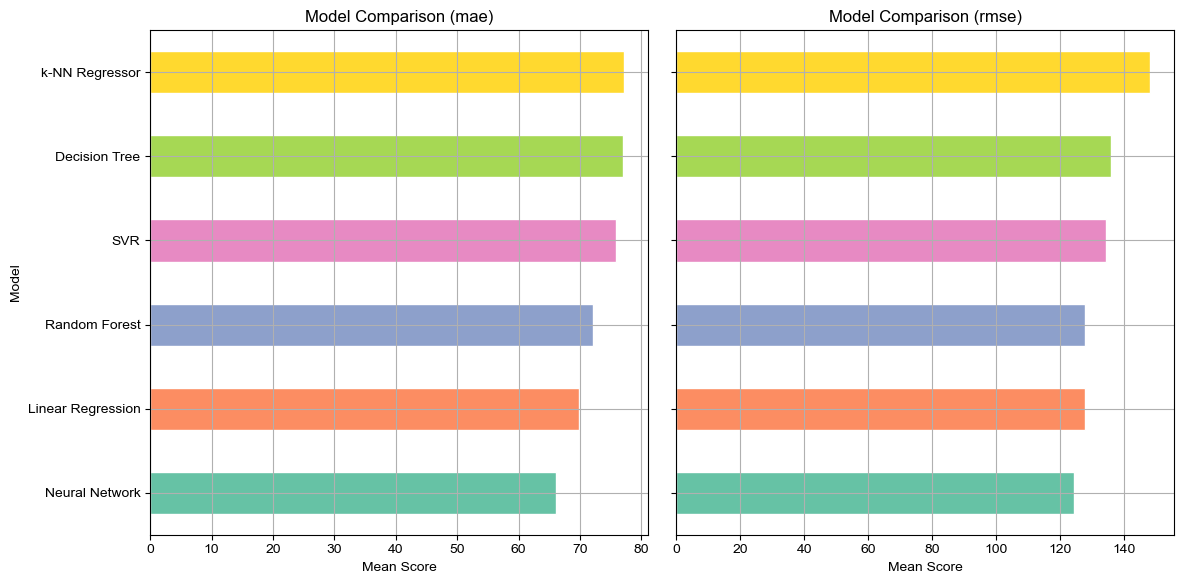

In [14]:
run_nested_regression_cv(X, y, models, param_grids, scoring_list=['rmse', 'mae'])

### HYPERPARAMETER TUNING USING OPTUNA FOR THE SELECTED MODEL

In [20]:
 def tune_model_with_optuna(X, y, model_class, param_grid,
                           scoring='r2', n_trials=50, cv_folds=5,
                           stratified=True, direction='maximize'):
    """
    Generic Optuna tuner with optional scaler injection and custom/derived metrics.
    """

    print("\n Starting Optuna Hyperparameter Tuning")
    print("=========================================")
    print(f" Model       : {model_class.__name__}")
    print(f" Scoring     : {scoring}")
    print(f" CV Folds    : {cv_folds}")
    print(f" Direction   : {direction}")
    print(f" Trials      : {n_trials}")
    print("=========================================\n")

    def get_scorer_callable(scoring):
        if scoring == 'rmse':
            return lambda est, X_val, y_val: -np.sqrt(mean_squared_error(y_val, est.predict(X_val)))
        elif scoring == 'rmsle':
            return lambda est, X_val, y_val: -np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(est.predict(X_val))))
        elif scoring == 'mape':
            return lambda est, X_val, y_val: -mean_absolute_percentage_error(y_val, est.predict(X_val))
        elif scoring == 'adjusted_r2':
            return lambda est, X_val, y_val: adjusted_r2_score(y_val, est.predict(X_val), X_val.shape[1])
        else:
            return scoring

    def adjusted_r2_score(y_true, y_pred, p):
        r2 = r2_score(y_true, y_pred)
        n = len(y_true)
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    scorer = get_scorer_callable(scoring)

    def needs_scaling(model_class):
        # Tree models don’t need scaling, most others do
        tree_keywords = ['tree', 'forest', 'boost', 'xgb']
        return not any(word in model_class.__name__.lower() for word in tree_keywords)

    def objective(trial):
        params = {k: v(trial) for k, v in param_grid.items()}
        base_model = model_class(**params)

        model = make_pipeline(StandardScaler(), base_model) if needs_scaling(model_class) else base_model

        cv = StratifiedKFold(cv_folds, shuffle=True, random_state=42) if stratified else KFold(cv_folds, shuffle=True, random_state=42)

        if isinstance(scorer, str):
            score = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1).mean()
        else:
            scores = []
            for train_idx, test_idx in cv.split(X, y):
                X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
                y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
                X_test = X.iloc[test_idx] if hasattr(X, "iloc") else X[test_idx]
                y_test = y.iloc[test_idx] if hasattr(y, "iloc") else y[test_idx]

                model.fit(X_train, y_train)
                scores.append(scorer(model, X_test, y_test))
            score = np.mean(scores)

        return score

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    print("\n Best Score Achieved:")
    print(f"   {study.best_value:.5f}")

    print("\n Best Hyperparameters Found:")
    param_table = [[k, v] for k, v in study.best_params.items()]
    print(tabulate(param_table, headers=["Hyperparameter", "Value"], tablefmt="fancy_grid"))


In [23]:

param_grid = {
    'hidden_layer_sizes': lambda trial: tuple(
        [trial.suggest_int('hidden_units', 50, 200)] * trial.suggest_int('n_layers', 1, 3)),
    'alpha': lambda trial: trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
    'learning_rate_init': lambda trial: trial.suggest_float('learning_rate_init', 0.001, 0.1, log=True),
    'random_state': lambda trial: 42,
    'activation': lambda trial: trial.suggest_categorical('activation', ['relu', 'tanh']),
    'batch_size': lambda trial: trial.suggest_categorical('batch_size', [32, 64, 128]),
    'solver': lambda trial: trial.suggest_categorical('solver', ['adam']),
    'learning_rate': lambda trial: trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
    'max_iter': lambda trial: trial.suggest_int('max_iter', 300, 500)
}

# Wrap your model class with early stopping inside the function
def model_with_early_stopping(**params):
    return MLPRegressor(
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,
        **params
    )

best_nn_params = tune_model_with_optuna(
    X_train, y_train,
    model_class=model_with_early_stopping,
    param_grid=param_grid,
    scoring='rmse',
    stratified=False,
    n_trials=40,
    direction='maximize'
)

[I 2025-03-28 17:48:40,912] A new study created in memory with name: no-name-136e217a-1615-47a0-990b-39860e852f0b



 Starting Optuna Hyperparameter Tuning
 Model       : model_with_early_stopping
 Scoring     : rmse
 CV Folds    : 5
 Direction   : maximize
 Trials      : 40



[I 2025-03-28 17:48:49,244] Trial 0 finished with value: -123.20158957574827 and parameters: {'hidden_units': 186, 'n_layers': 2, 'alpha': 0.001067564832072125, 'learning_rate_init': 0.010596735824594606, 'activation': 'relu', 'batch_size': 128, 'solver': 'adam', 'learning_rate': 'constant', 'max_iter': 430}. Best is trial 0 with value: -123.20158957574827.
[I 2025-03-28 17:49:16,774] Trial 1 finished with value: -128.33470705441513 and parameters: {'hidden_units': 166, 'n_layers': 3, 'alpha': 7.882174286608319e-05, 'learning_rate_init': 0.0015266197230836523, 'activation': 'relu', 'batch_size': 32, 'solver': 'adam', 'learning_rate': 'adaptive', 'max_iter': 461}. Best is trial 0 with value: -123.20158957574827.
[I 2025-03-28 17:49:39,035] Trial 2 finished with value: -132.65439872419367 and parameters: {'hidden_units': 117, 'n_layers': 3, 'alpha': 1.4131362505832914e-05, 'learning_rate_init': 0.027866341130823865, 'activation': 'relu', 'batch_size': 32, 'solver': 'adam', 'learning_rate


 Best Score Achieved:
   -123.20159

 Best Hyperparameters Found:
╒════════════════════╤══════════════════════╕
│ Hyperparameter     │ Value                │
╞════════════════════╪══════════════════════╡
│ hidden_units       │ 186                  │
├────────────────────┼──────────────────────┤
│ n_layers           │ 2                    │
├────────────────────┼──────────────────────┤
│ alpha              │ 0.001067564832072125 │
├────────────────────┼──────────────────────┤
│ learning_rate_init │ 0.010596735824594606 │
├────────────────────┼──────────────────────┤
│ activation         │ relu                 │
├────────────────────┼──────────────────────┤
│ batch_size         │ 128                  │
├────────────────────┼──────────────────────┤
│ solver             │ adam                 │
├────────────────────┼──────────────────────┤
│ learning_rate      │ constant             │
├────────────────────┼──────────────────────┤
│ max_iter           │ 430                  │
╘════════════

### MODEL EVALUATION USING CUSTOM FUNCTION ( METRICS, LEARNING CURVE, VALIDATION CURVES)

In [18]:

def evaluate_regression_model(
    model, X_train, y_train, X_test, y_test, cv=5,
    validation_params=None,  # <- Dict of {param_name: param_range}
    show_residuals=False, show_train_test_gap=False, show_pred_plot=False
):
    """
    Evaluates a regression model with optional visuals.

    Parameters:
    - model: regressor or pipeline
    - X_train, y_train: training data
    - X_test, y_test: test data
    - cv: folds for learning/validation curves
    - validation_params: dictionary of {param_name: param_range}
    - show_residuals: plot residuals vs predicted values
    - show_train_test_gap: compute and print train vs test RMSE gap
    - show_pred_plot: show y_pred vs y_test scatter plot
    """
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n" + "="*60)
    print(f" Test Set Evaluation: {model.__class__.__name__}")
    print("="*60)
    print(tabulate([
        ["R² Score", f"{r2:.4f}"],
        ["RMSE", f"{test_rmse:.4f}"],
        ["MAE", f"{mae:.4f}"],
        ["MAPE", f"{mape:.4f}"]
    ], headers=["Metric", "Value"], tablefmt="pretty"))

    if show_train_test_gap:
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        print(f"\n Train RMSE: {train_rmse:.4f}")
        print(f" Test RMSE:  {test_rmse:.4f}")
        print(f" Gap:        {abs(train_rmse - test_rmse):.4f}")

    if show_residuals:
        residuals = y_test - y_pred
        plt.figure(figsize=(8, 5))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title(f"Residual Plot: {model.__class__.__name__}")
        plt.grid()
        plt.tight_layout()
        plt.show()

    if show_pred_plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Prediction vs Actual: {model.__class__.__name__}")
        plt.grid()
        plt.tight_layout()
        plt.show()

    if cv > 1:
        print("\n Generating Learning Curve...")
        pipe = Pipeline([('scaler', StandardScaler()), ('reg', model)])
        train_sizes, train_scores, val_scores = learning_curve(
            pipe, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='neg_mean_squared_error', cv=cv, n_jobs=-1
        )
        train_rmse = np.sqrt(-np.mean(train_scores, axis=1))
        val_rmse = np.sqrt(-np.mean(val_scores, axis=1))
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_rmse, label='Training RMSE', marker='o')
        plt.plot(train_sizes, val_rmse, label='Validation RMSE', marker='s', linestyle='--')
        plt.xlabel("Training Set Size")
        plt.ylabel("RMSE")
        plt.title(f"Learning Curve: {model.__class__.__name__}")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    if validation_params:
        for param_name, param_range in validation_params.items():
            print(f"\n Generating Validation Curve for: {param_name}")
            pipe = Pipeline([('scaler', StandardScaler()), ('reg', model)])
            train_scores, val_scores = validation_curve(
                pipe, X_train, y_train,
                param_name=f'reg__{param_name}',
                param_range=param_range,
                scoring='neg_mean_squared_error',
                cv=cv, n_jobs=-1
            )
            train_rmse = np.sqrt(-np.mean(train_scores, axis=1))
            val_rmse = np.sqrt(-np.mean(val_scores, axis=1))
            plt.figure(figsize=(8, 6))
            labels = [str(p) for p in param_range]
            plt.plot(labels, train_rmse, label='Training RMSE', marker='o')
            plt.plot(labels, val_rmse, label='Validation RMSE', marker='s', linestyle='--')
            plt.xlabel(param_name)
            plt.ylabel("RMSE")
            plt.title(f"Validation Curve: {model.__class__.__name__} - {param_name}")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()



 Test Set Evaluation: MLPRegressor
+----------+------------------------+
|  Metric  |         Value          |
+----------+------------------------+
| R² Score |         0.5122         |
|   RMSE   |        134.9292        |
|   MAE    |        71.9031         |
|   MAPE   | 31259910919199080.0000 |
+----------+------------------------+

 Generating Learning Curve...


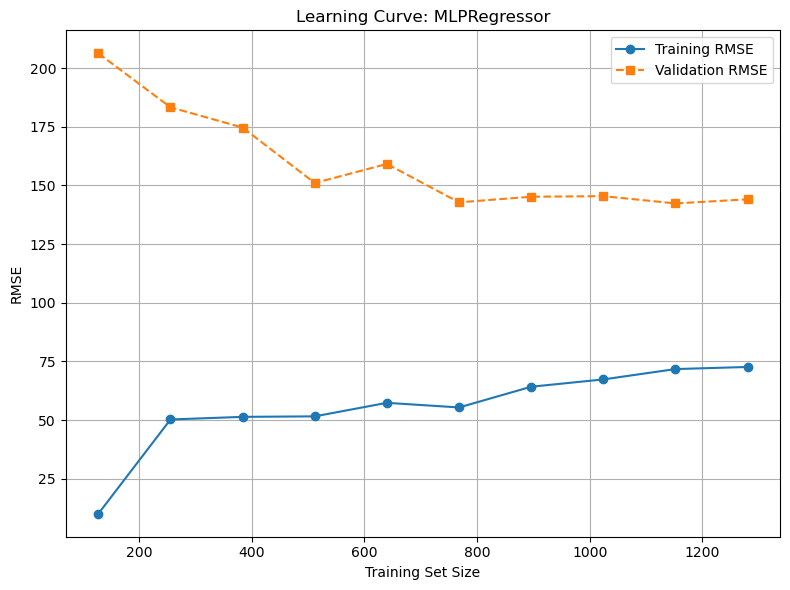

In [26]:
model = MLPRegressor(
    hidden_layer_sizes=(186,) * 2,
    activation='relu',
    solver='adam',
    alpha=0.001067564832072125,
    batch_size=128,
    learning_rate_init=0.010596735824594606,
    learning_rate='constant',
    max_iter=430,
    random_state=42
)

evaluate_regression_model(
    model, X_train, y_train, X_test, y_test
)

## CREATING A MODEL FOR THE RESTRICTED DATASET (WHERE PURCHASE = 1)

In [27]:
# RESTRICTED DATASET (PURCHASE = 1)
df_restricted = df[df['Purchase'] == 1].copy()
df_restricted.reset_index(drop=True, inplace=True)
summary_dataframe(df_restricted)


Summary Statistics:
╒══════════════════════╤═════════════╤════════════════╤══════════════════╤═════════════╤═════════════════╤════════════╤═══════════════════╤════════════════════════╕
│ Column Name          │ Data Type   │   Total Values │   Missing Values │   Missing % │   Unique Values │   Unique % │ Constant Column   │ Cardinality Category   │
╞══════════════════════╪═════════════╪════════════════╪══════════════════╪═════════════╪═════════════════╪════════════╪═══════════════════╪════════════════════════╡
│ sequence_number      │ int64       │           1000 │                0 │           0 │            1000 │      100   │ False             │ High                   │
├──────────────────────┼─────────────┼────────────────┼──────────────────┼─────────────┼─────────────────┼────────────┼───────────────────┼────────────────────────┤
│ US                   │ int64       │           1000 │                0 │           0 │               2 │        0.2 │ False             │ Low           

C:\Users\harsh\anaconda3\Lib\site-packages\data_science_hack_functions\exploratory.py:56: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  desc_numeric["Skewness"] = numeric_df.apply(lambda x: skew(x.dropna()), axis=0)
C:\Users\harsh\anaconda3\Lib\site-packages\data_science_hack_functions\exploratory.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  desc_numeric["Kurtosis"] = numeric_df.apply(lambda x: kurtosis(x.dropna()), axis=0)


### FEATURE ENGINEERING - FOR RESTRICTED DATASET

In [30]:
X_restricted = df_restricted.drop(columns=['Spending', 'sequence_number', 'Purchase'])
y_restricted = df_restricted['Spending']
X_train_restricted, X_test_restricted, y_train_restricted, y_test_restricted = train_test_split(X_restricted, y_restricted, test_size=0.2, random_state=42)
X_train_restricted.shape, X_test_restricted.shape, y_train_restricted.shape, y_test_restricted.shape

((800, 22), (200, 22), (800,), (200,))

In [31]:
Scaler_restricted = StandardScaler()
X_train_restricted_scaled = scaler.fit_transform(X_train_restricted)
X_test_restricted_scaled = scaler.transform(X_test_restricted)
X_train_restricted_scaled.shape, X_test_restricted_scaled.shape

((800, 22), (200, 22))

### MODEL SELECTION - FOR RESTRICTED DATASET

In [39]:
param_grids = {
    "Linear Regression": {},  # No hyperparameters to tune
    
    "k-NN Regressor": {
        'n_neighbors': [3, 5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    
    "Decision Tree": {
        'max_depth': [3, 5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    "SVR": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    },
    
    "Neural Network": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }
}

In [40]:
models = {
    "Linear Regression": LinearRegression(),
    "k-NN Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "SVR": SVR(),
    "Neural Network": MLPRegressor(max_iter=1000),
    "Random Forest": RandomForestRegressor()
}


 Running Nested CV for: Linear Regression

→ Scoring Metric: RMSE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  165.2471  | 17.5810 |
+------------+---------+
Best Hyperparameters:

→ Scoring Metric: MAE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  103.1931  | 9.0291  |
+------------+---------+
Best Hyperparameters:

 Running Nested CV for: k-NN Regressor

→ Scoring Metric: RMSE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  182.4225  | 28.1419 |
+------------+---------+
Best Hyperparameters:
   - regressor__metric: euclidean
   - regressor__n_neighbors: 10
   - regressor__weights: distance

→ Scoring Metric: MAE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  105.8933  | 9.0937  |
+------------+---------+
Best Hyperparameters:
   - regressor__metric: euclidean
   - regressor__n_neighbors: 15
   - regressor__weights: distance

 Running Nested CV for: Decision T

C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  165.3063  | 15.7035 |
+------------+---------+
Best Hyperparameters:
   - regressor__activation: relu
   - regressor__alpha: 0.0001
   - regressor__hidden_layer_sizes: (50,)
   - regressor__learning_rate: constant
   - regressor__solver: adam

→ Scoring Metric: MAE


C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  100.5899  | 7.2373  |
+------------+---------+
Best Hyperparameters:
   - regressor__activation: relu
   - regressor__alpha: 0.01
   - regressor__hidden_layer_sizes: (50,)
   - regressor__learning_rate: constant
   - regressor__solver: adam

 Running Nested CV for: Random Forest

→ Scoring Metric: RMSE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  160.8737  | 15.7069 |
+------------+---------+
Best Hyperparameters:
   - regressor__bootstrap: True
   - regressor__max_depth: 10
   - regressor__min_samples_leaf: 2
   - regressor__min_samples_split: 2
   - regressor__n_estimators: 100

→ Scoring Metric: MAE
+------------+---------+
| Mean Score | Std Dev |
+------------+---------+
|  95.7301   | 6.3680  |
+------------+---------+
Best Hyperparameters:
   - regressor__bootstrap: True
   - regressor__max_depth: 10
   - regressor__min_samples_leaf: 2
   - regressor__min_samples_split:

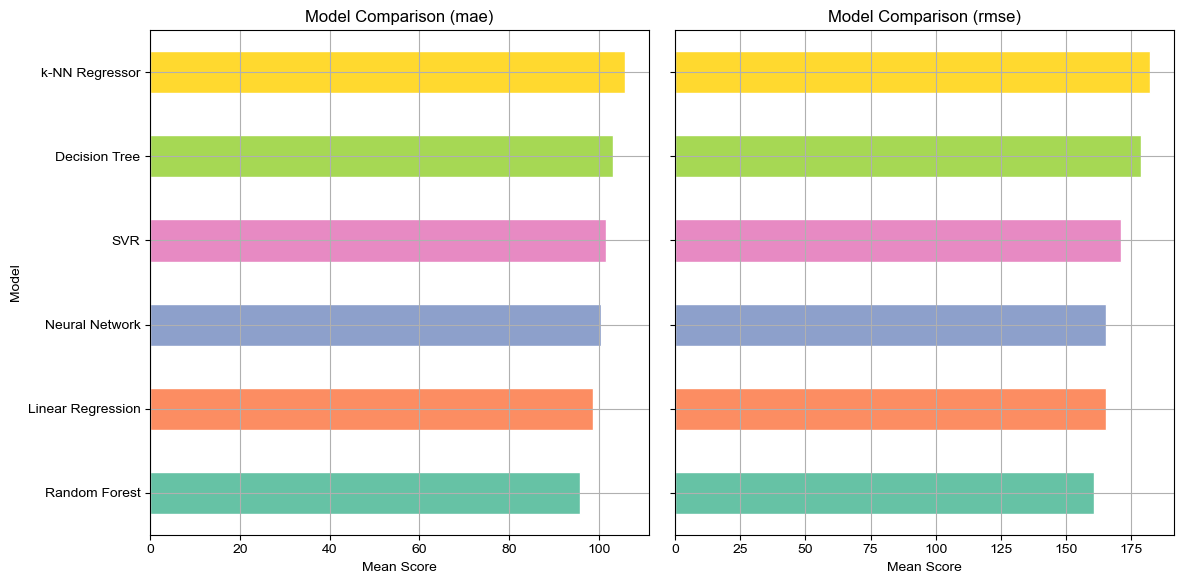

In [41]:
run_nested_regression_cv(X_restricted, y_restricted, models, param_grids, scoring_list=['rmse', 'mae'])

### HYPERPARAMETER TUNING - FOR RESTRICTED DATASET

In [43]:
# Define parameter search space for Random Forest
param_grid = {
    'n_estimators': lambda trial: trial.suggest_int('n_estimators', 50, 300),
    'max_depth': lambda trial: trial.suggest_int('max_depth', 3, 20),
    'min_samples_split': lambda trial: trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': lambda trial: trial.suggest_int('min_samples_leaf', 1, 5),
    'max_features': lambda trial: trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    'bootstrap': lambda trial: trial.suggest_categorical('bootstrap', [True, False]),
    'random_state': lambda trial: 42
}


# Tune the model
best_rf_params = tune_model_with_optuna(
    X_train, y_train,
    model_class=RandomForestRegressor,
    param_grid=param_grid,
    scoring='rmse',    
    stratified=False,
    n_trials=40,
    direction='maximize'
)

# Show the best hyperparameters
best_rf_params

[I 2025-03-28 18:59:07,848] A new study created in memory with name: no-name-669c29a6-3171-414d-a8b1-fa2954ad5c76



 Starting Optuna Hyperparameter Tuning
 Model       : RandomForestRegressor
 Scoring     : rmse
 CV Folds    : 5
 Direction   : maximize
 Trials      : 40



[I 2025-03-28 18:59:13,163] Trial 0 finished with value: -133.00881787323817 and parameters: {'n_estimators': 173, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: -133.00881787323817.
[I 2025-03-28 18:59:17,818] Trial 1 finished with value: -133.56063858049657 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -133.00881787323817.
[I 2025-03-28 18:59:22,729] Trial 2 finished with value: -133.58584271123405 and parameters: {'n_estimators': 117, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: -133.00881787323817.
[I 2025-03-28 18:59:43,395] Trial 3 finished with value: -139.01635036254112 and parameters: {'n_estimators': 285, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_f


 Best Score Achieved:
   -125.43287

 Best Hyperparameters Found:
╒═══════════════════╤═════════╕
│ Hyperparameter    │   Value │
╞═══════════════════╪═════════╡
│ n_estimators      │     265 │
├───────────────────┼─────────┤
│ max_depth         │       5 │
├───────────────────┼─────────┤
│ min_samples_split │       3 │
├───────────────────┼─────────┤
│ min_samples_leaf  │       2 │
├───────────────────┼─────────┤
│ max_features      │         │
├───────────────────┼─────────┤
│ bootstrap         │    True │
╘═══════════════════╧═════════╛


### MODEL EVALUATION FOR RESTRICTED DATASET


 Test Set Evaluation: RandomForestRegressor
+----------+------------------------+
|  Metric  |         Value          |
+----------+------------------------+
| R² Score |         0.5451         |
|   RMSE   |        130.2984        |
|   MAE    |        72.9605         |
|   MAPE   | 25324237405191208.0000 |
+----------+------------------------+

 Generating Learning Curve...


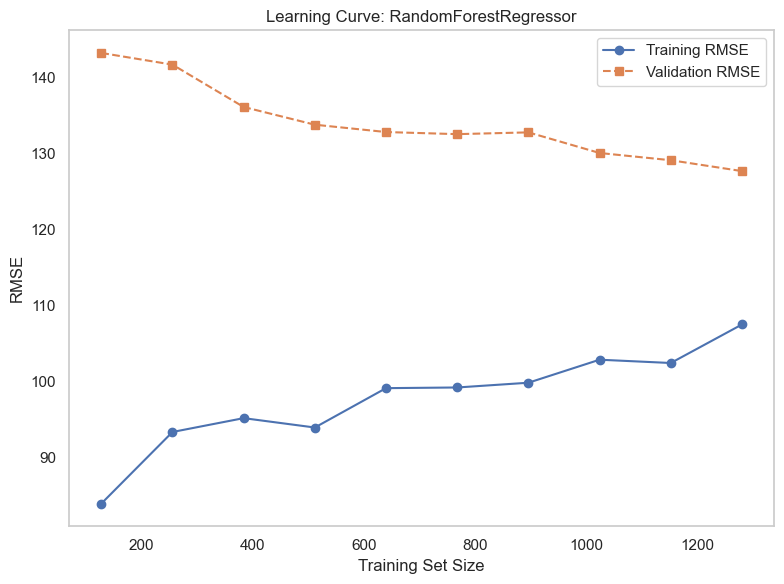

In [44]:
best_rf_model = RandomForestRegressor(
    n_estimators=265,
    max_depth=5,
    min_samples_split=3,
    min_samples_leaf=2,
    max_features=None,
    bootstrap=True,
    random_state=42
)

evaluate_regression_model(
    best_rf_model, X_train, y_train, X_test, y_test
)